In [1]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
# import yfinance as yf
from yahoo_fin.stock_info import get_data
# import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.decomposition import KernelPCA
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

ticker ="^990100-USD-STRD" #"^FTSE" #"^RUT" #"^GSPC" #"^VIX" #"^990100-USD-STRD"
n_components = 250

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [2]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker=ticker, start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP(n_components=n_components)
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())
decomposer = KernelPCA(n_components=n_components)
decomposed =decomposer.fit_transform(frame.select('embeddings').to_series().to_list())


In [3]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
frame = frame.with_columns(pl.Series(name = 'decomposed', values = decomposed))

# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

In [4]:
frame = frame.sort('date').set_sorted('date').with_columns(pl.col('close').rolling_std(by='date', window_size = '1w').alias('std'))

In [5]:
frame = frame.drop_nulls()

In [6]:
frame = frame.with_columns(pl.col('close').rolling_mean(window_size = '1mo', by='date').alias('mean'))

In [7]:
frame.with_columns(pl.col('close').qcut([0.10,0.20,0.80,0.90]))

date,label,sentence,embeddings,close,quarter,year,reduced,decomposed,std,mean
date,i64,str,list[f64],cat,i8,i32,list[f32],list[f64],f64,f64
2008-08-11,1,"""New York Senat…","[-0.034912, 0.019608, … 0.00705]","""(0.00677922017…",3,2008,"[11.498298, 6.229567, … 4.980131]","[-0.087196, 0.10759, … -0.004106]",0.003269,0.008764
2008-08-12,0,"""Gold plunges t…","[-0.044525, 0.028824, … -0.011269]","""(-0.0124947021…",3,2008,"[11.523719, 6.195405, … 4.984311]","[-0.061607, 0.118246, … 0.005354]",0.009328,-0.000217
2008-08-13,0,"""DreamWorks Ani…","[-0.032074, 0.025146, … 0.015137]","""(-0.0124947021…",3,2008,"[11.498337, 6.212471, … 4.982409]","[-0.046698, 0.115567, … -0.002803]",0.009879,-0.003928
2008-08-14,1,"""Temecula Valle…","[-0.043121, 0.02681, … 0.010452]","""(-0.0068066192…",3,2008,"[11.459106, 6.190988, … 4.977581]","[-0.079004, 0.114393, … 0.008608]",0.008967,-0.001921
2008-08-15,1,"""Free Rainwater…","[-0.02565, 0.041412, … -0.005875]","""(-0.0068066192…",3,2008,"[11.525765, 6.159205, … 4.982441]","[-0.053156, 0.12775, … 0.004807]",0.008564,-0.00216
…,…,…,…,…,…,…,…,…,…,…
2015-12-04,1,"""Sprott Focus T…","[-0.014244, 0.033936, … -0.007206]","""(0.00677922017…",4,2015,"[5.13034, 4.030962, … 4.792701]","[0.080402, -0.099636, … -0.019586]",0.009651,-0.00093
2015-12-07,0,"""Rentrak Announ…","[0.006672, 0.037231, … 0.026917]","""(-0.0068066192…",4,2015,"[5.511795, 4.176407, … 4.814314]","[0.166768, -0.128027, … -0.00953]",0.009771,-0.000942
2015-12-08,0,"""ATWOOD OCEANIC…","[-0.003252, 0.035645, … 0.014435]","""(-0.0124947021…",4,2015,"[5.263071, 4.017231, … 4.809952]","[0.111097, -0.047489, … 0.007595]",0.008396,-0.001388


In [8]:
returns = frame.select('close').to_series()

# Calculate the quantiles
q10 = returns.quantile(0.10)
q20 = returns.quantile(0.20)
q80 = returns.quantile(0.80)
q90 = returns.quantile(0.90)

# Use qcut to bin the returns into four categories based on the quantiles
# y = pl.qcut(returns, [0, q10, q20, q80, q90, float('inf')], labels=False)

# One-hot encode the resulting categories to create a multinomial Y variable
# y = pl.concat_list([pl.when(y == i).then(1).otherwise(0).alias(f"Class {i+1}") for i in range(4)], how="horizontal")


In [21]:
frame = (
    frame
    .with_columns(
        pl.when((pl.col('close')>=(q90))).then(1)
        .when((pl.col('close')>=(q80)) & (pl.col('close')<(q90))).then(2)
        .when((pl.col('close')>=(q20)) & (pl.col('close')<(q80))).then(3)
        .when((pl.col('close')>=(q10)) & (pl.col('close')<(q20))).then(4)
        .when((pl.col('close')<(q10))).then(5)
        .alias('quantiles')
    )
)

## Getting lineplots

In [22]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame, model_type: str, intercept: bool = True, start_year: int =2008):
    if model_type == 'ols':
        model = LinearRegression(fit_intercept=intercept)
    elif model_type == 'ridge':
        model = Ridge(fit_intercept=intercept)
    elif model_type == 'lasso':
        model = Lasso(fit_intercept=intercept)
    elif model_type == 'elastic net':
        model = ElasticNet(fit_intercept=intercept)

    df = df.filter(pl.col('date').dt.year().ge(start_year))

    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y[:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    in_sample = reg.predict(X[:ind])
    predicted = np.append(in_sample, out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', y_col, 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = max(out_of_sample) + 0.05, s = "Out of Sample")

    # print("Coefficients: \n", reg.coef_)
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=0,s=f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.01,s=f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.02,s=f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.03,s= f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")

    print(f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    print(f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    print(f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    print(f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")
    print(f"Average of the prediction : {np.mean(out_of_sample)}")
    print(f"Average of the true values : {np.mean(y[ind:])}")
    print(f"Std of the prediction : {np.std(out_of_sample)}")
    print(f"Std of the true values : {np.std(y[ind:])}")

    return

Mean squared error (in sample): 0.00
Coefficient of determination (in sample): 0.22
Mean squared error (out of sample): 0.00
Coefficient of determination (out of sample): -56.30
Average of the prediction : 0.03063402212818021
Average of the true values : -7.277308110384134e-05
Std of the prediction : 0.04027067842398077
Std of the true values : 0.006814888499697596


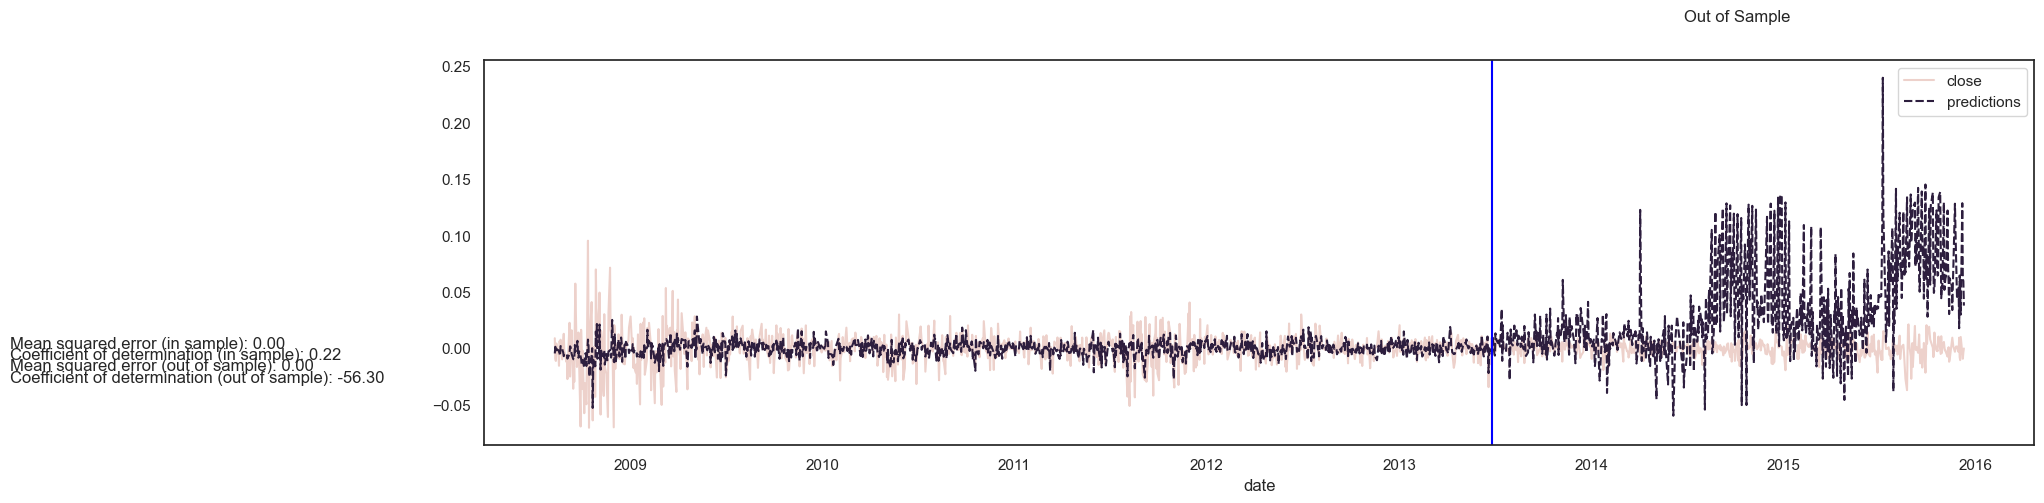

In [23]:
get_linear_regression(x_col='reduced', y_col='close', df=frame, model_type = 'ols', intercept = False, start_year = 2008)

## Getting Logistic Regression

In [24]:
model = LogisticRegression(penalty=None, multi_class='multinomial')
df = frame 
x_col = "embeddings"
y_col = "quantiles"

In [25]:
X = df.select(pl.col(x_col)).to_series().to_list()
y = df.select(pl.col(y_col)).to_series().to_list()
# y = np.argmax(y, axis=1)

ind = -int(len(X)/3)

X_test = X[ind:]
X_train = X[:ind]

y_test = y[ind:]
y_train = y[:ind]


reg = model.fit(X[:ind], y[:ind])

out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X_test))
in_sample = reg.predict(X_train)
predicted = np.append(in_sample, out_of_sample)

c:\Users\faune\miniconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6136363636363636
Precision: 0.5562824598360038
Recall: 0.6136363636363636
F1 score: 0.5828903077080847
Confusion matrix:
 [[  0   1  17   0   3]
 [  0   3  43   2   3]
 [  2  27 347  15  35]
 [  0   2  48   0   6]
 [  0   0  17   0   1]]


C:\Users\faune\AppData\Local\Temp\ipykernel_14256\1640233139.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(counts.to_pandas().index)
C:\Users\faune\AppData\Local\Temp\ipykernel_14256\1640233139.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['10%', '20%', '80%', '90%'])
C:\Users\faune\AppData\Local\Temp\ipykernel_14256\1640233139.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(['10%', '20%', '80%', '90%'])


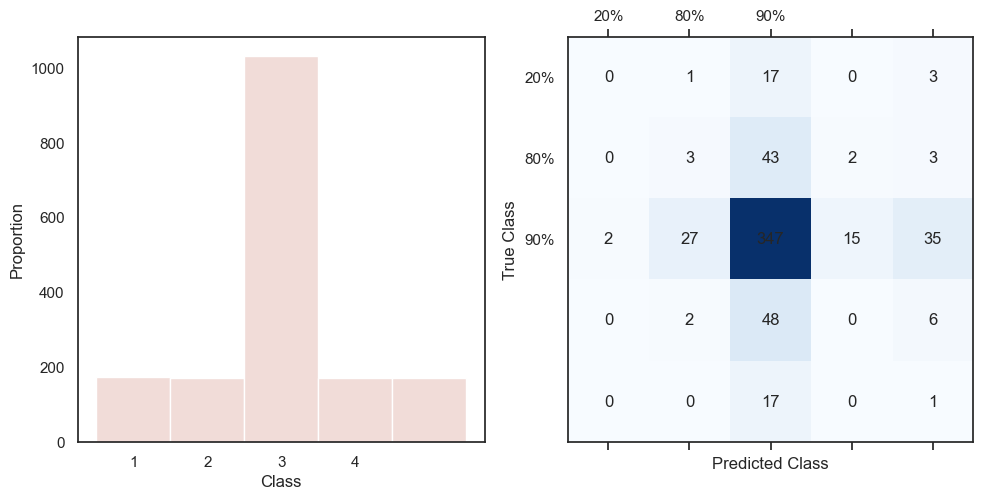

In [30]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

# Load the data into a Pandas DataFrame
# df = pd.read_csv('data.csv')

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

# Train a multinomial logistic regression model on the training data
# model = LogisticRegression()
# model.fit(X_train, y_train)

# df = df.to_pandas()

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_mat = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print('Confusion matrix:\n', conf_mat)

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the proportion of observations in each class
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the proportion of observations in each class
counts = df['quantiles'].value_counts()
# axs[0].bar(counts.index.to_numpy(), counts.values / len(df))
sns.histplot(data=df.to_pandas(), x='quantiles', ax=axs[0], discrete=True)
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Proportion')
axs[0].set_xticklabels(counts.to_pandas().index)


# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
axs[1].matshow(cm, cmap=plt.cm.Blues)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[1].text(j, i, cm[i, j], ha='center', va='center')
axs[1].set_xlabel('Predicted Class')
axs[1].set_ylabel('True Class')
axs[1].set_xticklabels(['10%', '20%', '80%', '90%'])
axs[1].set_yticklabels(['10%', '20%', '80%', '90%'])

plt.tight_layout()
plt.show()